In [1]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST'
tr_fmnist = datasets.FashionMNIST(data_folder,
                               download=True,
                               train=True)
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download=True,
                                   train=False)
tr_images, tr_targets = tr_fmnist.data, tr_fmnist.targets
val_images, val_targets = val_fmnist.data, val_fmnist.targets

In [2]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y, = x, y
    def __getitem__(self, ix):
        x,y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
    
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [4]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    val = FMNISTDataset(val_images, val_targets)
    tr_dl = DataLoader(train,
                        batch_size=int(len(tr_images)/50), # len/50=1200
                        shuffle=True)
    val_dl = DataLoader(val,
                        batch_size=len(val_images),
                        shuffle=False)
    return tr_dl, val_dl

In [5]:
@torch.no_grad()
def val_loss(x,y,model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [6]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [7]:
train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]
for epoch in range(30):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [],[]
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x,y = batch
        val_is_correct = accuracy(x,y,model)
        validation_loss = val_loss(x,y,model)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Final Training Loss was 0.16 and Final Validation Loss was 0.4


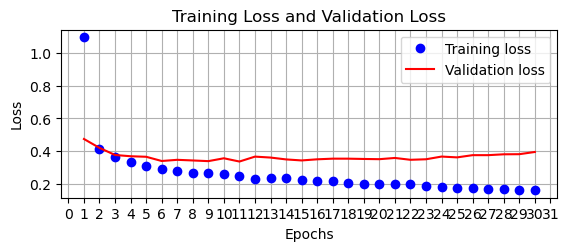


 Final Training Accuracy was 0.94 and Final Validation Accuracy was 0.88


C:\Users\eshlom\AppData\Local\Temp\1\ipykernel_27040\2154640722.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


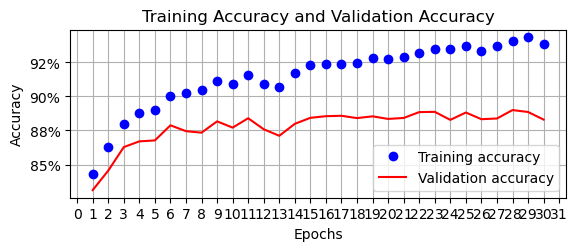

In [13]:
epochs = np.arange(30)+1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
print(f'Final Training Loss was {round(train_losses[-1], 2)} and Final Validation Loss was {round(val_losses[-1], 2)}')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
print(f'\n Final Training Accuracy was {round(train_accuracies[-1], 2)} and Final Validation Accuracy was {round(val_accuracies[-1], 2)}')
plt.show()